# Xue & Leibler, PNAS 2016

At each generation:

1. individuals develop a phenotype according to their phenotype distribution $\pi$: $\pi_i \in [0,1]$ is the probability that a specific individual will develop to phenotype $\phi_i$.
1. the fitness of individuals is set according to their phenotype and the environment $\epsilon \in {0, 1}$.
. individuals reproduce: the relative contribution (fitness) of individuals with phenotype $\phi_i$ in environment $\epsilon_j$ to the next generation is $\frac{\omega_i^{(j)}}{\sum_k{\phi_k^j}}$.
1. each offspring phenotype distribution is inherited from its parent, where a fraction $1-\eta$ is determined according to the parent phenotype distribution and a fraction $\eta$ is determined according to the parent phenotype; the offspring distribution is $\pi_i' = (1-\eta)\phi_i + \eta * \delta_{i,k}$, where $k$ is the parent phenotype.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style='ticks', context='paper')

In [72]:
def simulation(N, n, η, ω0, ω1, π0, ϵ=None):
    """Run a single simulation.
    
    Parameters
    ----------
    N : int
        constant population size
    n : int
        number of generations
    η : float
        learning rate, 0 <= η <= 1
    ω0, ω1 : float
        two fitness values for the two phenotyes in the two environments, ω > 0
    π0 : float
        initial value for π
    ϵ : numpy.ndarray
        ϵ[t] is the environment at time t
    """
    ω = np.array(
        [
            [ω0, ω1],
            [ω1, ω0]
        ],
    dtype=float)
    
    if ϵ is None:
        ϵ = np.random.randint(0, 2, n)
    # π[t, i] is the probability for phenotype 0 at individual i at time t
    π = np.zeros((n, N), dtype=float)
    π[0, :] = np.random.normal(π0, np.sqrt(π0 / 10), N)
    π[0, π[0, :] < 0] = 0
    π[0, π[0, :] > 1] = 1

    for t in range(n - 1):
        # phenotype of each individual
        φ = np.zeros(N, dtype=int)
        φ[np.random.random(N) > π[t, :]] = 1
        # fitness of each invidividual in current environment
        ω_t = ω[ϵ[t], φ]
        ω_t = ω_t / ω_t.sum()
        # selection & reproduction; idx is the indexes of reproducing individuals
        idx = np.random.choice(N, N, True, ω_t)
        # offspring phenotype probability
        π[t + 1, :] = (1 - η) * π[t, idx] + η * (φ[idx] == 0)
        
    return π

# N=100
# n=99
# η=0.1
# ω0=2
# ω1=0.2
# π0=0.5
# p0 = 0.5
# ϵ = np.random.choice(2, n, True, [p0, 1 - p0])
# π = simulation(N, n, η, ω0, ω1, π0, ϵ)
# print(0)
# print("Initial π: {:.2f}+-{:.4f}\nFinal π: {:.2f}+-{:.4f}".format(
#     π[0,:].mean(), π[0,:].std(), π[-1,:].mean(), π[-1,:].std()
# ))

In [70]:
def plot_π(π, ϵ, ax=None):    
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(8):
        low, high = np.percentile(π, [0.5*(2**i), 100-0.5*(2**i)], 1)
        ax.fill_between(range(π.shape[0]), low, high, color='b', alpha=0.1)
    ax.plot(π.mean(axis=1), c='y', lw=3)
    ax.axhline((ϵ==0).mean(), color='k')
    ax.set(
        ylim=(0, 1),
        ylabel='$π_A$',
        xlabel='t'
    )
    ax.set_clip_on(False)
    sns.despine()
    return ax
    
# plot_π(π, ϵ);

In [71]:
def plot_logNtN0(π, ω0, ω1, p0, ϵ, ax=None):    
    if ax is None:
        fig, ax = plt.subplots()
    
    # estimated log(Nt/N0)
    ω = np.array(
        [
            [ω0, ω1],
            [ω1, ω0]
        ],
    dtype=float)
    π_bar = π.mean(axis=1)
    Δ = np.log(π_bar * ω[ϵ, 0] + (1 - π_bar) * ω[ϵ, 1]) # eq. 17
    logNtN0 = Δ.cumsum() # eq. 18
    ax.plot(logNtN0, 'b')
    # max possible log(Nt/N0)
    maxlogNtN0 = np.repeat(np.log(ω0), logNtN0.size).cumsum()
    ax.plot(maxlogNtN0, 'y') 
    # bet-hedging  log(Nt/N0), eq. 11
    ax.plot(np.repeat(
        p0 * np.log(p0 * ω0 + (1 - p0) * ω1) + (1 - p0) * np.log(p0 * ω1 + (1 - p0) * ω0),
        logNtN0.size
    ).cumsum(), 'k')

    ax.set(
        xlabel='t',
        ylabel='$log(N_t/N_0)$',
        yticks=np.arange(0, maxlogNtN0.max(), 20)
    )
    ax.set_clip_on(False)
    sns.despine()
    return ax

# plot_logNtN0(π, ω0, ω1, p0, ϵ);

# Figure 2

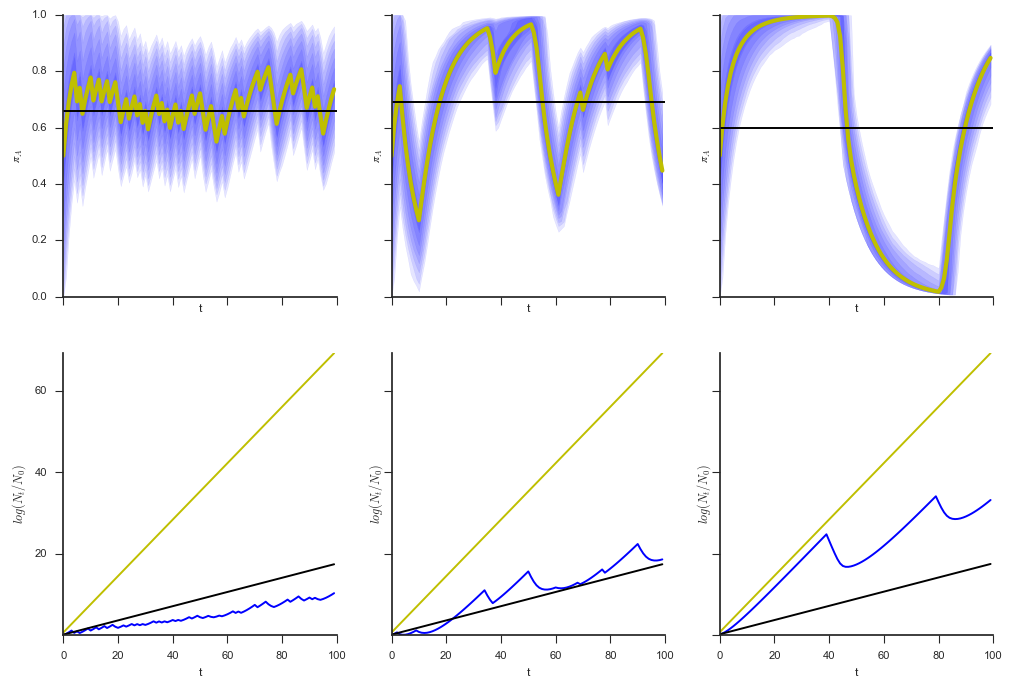

In [69]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey='row')

N=100000
n=100
η=0.1
ω0=2
ω1=0.2
π0=0.5
p0 = 0.5

## Fig. 2A
ϵ = np.random.choice(2, n, True, [0.7, 0.3])
π = simulation(N, n, η, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0, 0])
plot_logNtN0(π, ω0, ω1, 0.7, ϵ, ax=ax[1,0])

## Fig. 2B
ϵ, a = np.zeros(n, dtype=int), 0
while a < ϵ.size:
    a += np.random.geometric(1/10)
    g = np.random.geometric(1/5)
    ϵ[a: a + g] = 1
    a += g
π = simulation(N, n, η, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0,1])
plot_logNtN0(π, ω0, ω1, 0.7, ϵ, ax=ax[1,1])

## Fig. 2C
ϵ = np.array([0] * 40 + [1] * 40 + [0] * 20)
π = simulation(N, n, η, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0,2])
plot_logNtN0(π, ω0, ω1, 0.7, ϵ, ax=ax[1,2]);